## Imports and configuration

In [65]:
import os, re, requests, threading, time, tldextract
import numpy as np
import pandas as pd
import seaborn as sns
import wikipedia as wp
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

# Configuring matplotlib to output opaque images to avoid issues with dark mode
import matplotlib as mpl
mpl.rcParams["savefig.facecolor"] = "w"

# We do only read operations, therefore no user config is necessary.
# Normally the system crashes when there is no user config unless we tell it otherwise with this environment variable.
#   0 is default
#   1 means ignore the config
#   2 means ignore the config and don't throw warnings
os.environ["PYWIKIBOT_NO_USER_CONFIG"] = "2"

# Now we can import pywikibot
import pywikibot as pwb
import pywikibot.data.api as api

# Then we can setup references for Wikipedia and Wikidata
wiki_site = pwb.Site(code="en", fam="wikipedia")
data_site = pwb.Site(code="wikidata", fam="wikidata")
repo = data_site.data_repository()

# Setting important dates
stime = "2015070100"
etime = str(datetime.today().date()).replace("-", "") + "00"

# We list here the search terms for EPFL
epfl_alts = [
    "EPFL",
    "École Polytechnique Fédérale de Lausanne",
    "Swiss Federal Institute of Technology",
    "EPF Lausanne",
    "ETH Lausanne",
    "Poly Lausanne",
]

# URL and headers for pageview website
pv_url = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/%s/daily/%s/%s"
pv_head = {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.182 Safari/537.36"}

# Setting paths
im_path = "graphs"

Let's generate a list of all the pages that mention EPFL. We set `namespace=0` as this namespace is the one that contains regular pages. Note that searches from Pywikibot are ordered alphabetically by default, unlike what the Wikipedia API does.

In [5]:
def save_pagenames(pnames):
    with open("pagenames.txt", "w", encoding="utf-8") as f:
        f.write("\n".join(pnames), )
        
def load_pagenames():
    try:
        with open("pagenames.txt", "r", encoding="utf-8") as f:
            return f.read().split("\n")
    except:
        return []

def collect_pages(site, keywords):
    # Search for each keyword
    searches = [site.search(kw.lower(), where="text", namespaces=0) for kw in keywords]
    
    # Get the pages and flatten
    pages_raw = [list(s) for s in searches]
    pages = list(set([item for sublist in pages_raw for item in sublist]))
    ret = {}
    old_names = [] # load_pagenames()
    ignored = []
    
    # We filter out pages that do not have a WikiData item
    for p in tqdm(pages):
        try:
            if p.title() not in old_names:
                x = p.data_item().title()
        except:
            ignored.append(p.title())
            continue

        ret[x] = p
    
    new_pnames = list(set(old_names + [p.title() for p in ret]))
    save_pagenames(new_pnames)
    print(ignored)
    return ret

In [6]:
epfl_pages = collect_pages(wiki_site, epfl_alts)
print(len(epfl_pages), "pages currently tracked.")

100%|██████████████████████████████████████████████████████████████████████████████| 5001/5001 [31:12<00:00,  2.67it/s]

['Niko Geldner', 'Eastern Pennsylvania Football League', 'Kristin Schirmer']
4998 pages currently tracked.


It is important to note that Wikipedia started storing page view statistics since July 1st, 2015. This means we will not have any data available before that time.

In [15]:
list(epfl_pages.items())[:10]

[('Q696817', Page('Mediterranean and Middle East theatre of World War II')),
 ('Q2908764', Page('Tomorrowland Transit Authority PeopleMover')),
 ('Q29266709', Page('Sandro Carrara')),
 ('Q22691484', Page('Annalisa Buffa')),
 ('Q790012', Page('Out-of-body experience')),
 ('Q6641499', Page('List of stories set in a future now past')),
 ('Q2208719', Page('Imee Marcos')),
 ('Q5347504', Page('Effluent sewer')),
 ('Q7892', Page('Drinking water')),
 ('Q7222877', Page('Grading systems by country'))]

## Accessing a page

Let's look at the different ways we can refer to a given page. We will be using Martin Vetterli's page for our examples.

In [16]:
# We can get a page by name
page = pwb.Page(wiki_site, u"Martin Vetterli")
page

Page('Martin Vetterli')

In [17]:
# We can get its data reference
item = page.data_item()
item

ItemPage('Q6776811')

In [18]:
# We can get the reference directly
item = pwb.ItemPage(repo, "Q6776811")
item

ItemPage('Q6776811')

In [19]:
# And we can get all the pages linked to this reference through WikiData
for k, v in dict(item.sitelinks).items():
    print(k + "\n\t" + v.ns_title())

commonswiki
	Category:Martin Vetterli
dewiki
	Martin Vetterli
enwiki
	Martin Vetterli
frwiki
	Martin Vetterli
frwikiquote
	Martin Vetterli


## Page Views

In [22]:
req = api.Request(site=data_site, parameters={'action': 'query',
                                                'titles': item,
                                                'prop': 'pageviews',
                                                'pvipdays': 1000})

print("As the warning says, the default API request gives us a maximum of", len(req.submit()['query']['pages'][str(item.pageid)]['pageviews']), "days of data. This is insufficient.")

As the warning says, the default API request gives us a maximum of 60 days of data. This is insufficient.


In [55]:
# Set dates
pp_first = datetime.strptime(stime, "%Y%m%d00").strftime("%B %d, %Y").replace(" 0", " ")
pp_today = datetime.today().strftime("%B %d, %Y").replace(" 0", " ")

# Request data
page_name = "Martin_Vetterli"
r = requests.get(pv_url % (page_name, stime, etime), headers=pv_head)
print("Digging deeper into the API, we see we have access to", len(r.json()['items']), "days of pageview data since", pp_first, "as of", pp_today + ".")

Digging deeper into the API, we see we have access to 2063 days of pageview data since July 1, 2015 as of February 22, 2021.


## Mentions of EPFL in a page

In [20]:
def pagecounts(page, strings):
    return [page.text.count(s) for s in strings]

In [24]:
pcs = pagecounts(page, epfl_alts)
dict(zip(epfl_alts, pcs))

{'EPFL': 12,
 'École Polytechnique Fédérale de Lausanne': 6,
 'Swiss Federal Institute of Technology': 0,
 'EPF Lausanne': 0,
 'ETH Lausanne': 0,
 'Poly Lausanne': 0}

## Mentions over time

For `getPageChanges`, we recover all revisions at once at it is significantly faster to do that than to call `page.getOldVersion` continuously.

It is important to note that our process is simplified to improve performance by minimizing the number of revisions requested; if a page had 5 mentions in 2008, 5 in 2010, but 4 in 2009, the 4 will be glossed over as we assume the amount of such cases will be rare and insignificant.

Getting the revisions without the content is approximately 7 times faster on large pages (35 vs. 5 seconds), while getting the text from the revisions or from `getOldVersion` takes the same amount of time. However we are still getting faster results for revisions with content when it is part of our functions.

In [ ]:
import threading

class BackgroundGenerator(threading.Thread):
    def __init__(self, generator):
        threading.Thread.__init__(self)
        self.queue = Queue.Queue(1)
        self.generator = generator
        self.daemon = True
        self.start()

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def next(self):
            next_item = self.queue.get()
            if next_item is None:
                 raise StopIteration
            return next_item

In [ ]:


gen = page.revisions(content=True)
check = True
start = time.time()
while check:
    try:
        n = next(gen)
    except:
        break

end = time.time()
print(end-start)



gen = page.revisions(content=True)
start = time.time()
list(gen)
    
end = time.time()
print(end-start)


In [ ]:
list(page.latest_revision.keys())

In [ ]:
page

In [ ]:
page.()

In [46]:
page.revision_count()

start = time.time()
list(page.revisions())
end = time.time()

print(end-start)

start = time.time()
[x for x in page.revisions()]
end = time.time()

print(end-start)

0.5911023616790771
0.6535177230834961


In [ ]:
def getMentionCounts(rev, strings):
    return

In [ ]:
def getCounts(revs, strings, idx):
    page = revs[idx]
    return sum([page.text.count(s) for s in strings])

def getOrUpdate(revs, strings, counts, idx, changes):
    if idx not in counts:
        temp = getCounts(revs, strings, idx)
        counts[idx] = temp
        
        # Do not consider the count if an earlier revision had more
        if not any([counts[k] > temp for k in counts.keys() if k < idx]):
            changes[temp] = min(changes.get(temp) or idx, idx) 
    
    return counts[idx]

def getMentions(revs, strings, code):
    if not getCounts(revs, strings, 0):
        return None
    
    revs = list(page.revisions(reverse=True, content=True))

    # Start with whole scope
    queue = [(0, len(revs) - 1)]
    
    # To avoid double checking revisions we store the counts here
    cnts = {}
    
    # And here we store the count-index pairs
    changes = {}

    while queue:
        # Process first element
        r0, r1 = queue[0]
        queue = queue[1:]

        # Only proceed if current scope covers multiple indices
        if r0 != r1:
            # Get counts for both indices
            v0 = getOrUpdate(revs, strings, cnts, r0, changes)
            v1 = getOrUpdate(revs, strings, cnts, r1, changes)

            # Only proceed if there is a change of count in the current scope
            if v0 != v1 and abs(r1 - r0) > 1:
                mid = (r0 + r1) // 2
                queue.extend([(r0, mid), (mid, r1)])

    changes = {revs[v]["timestamp"]: k for k, v in changes.items()}
    changes = {datetime.combine(k.date(), k.time()): v for k, v in changes.items()}
    
    # Here we simplify our data to a maximum of one point per month (we take the last one)
    changes = pd.Series(changes, name="Mentions").sort_index().groupby(pd.Grouper(freq="1M")).nth(-1)
    return changes

In [ ]:
pms = getMentions(page, epfl_alts)
pms

In [ ]:
pms.plot(linestyle='--', marker='o')

## TEMPORARY, NEED TO ABSTRACT THE ARRAY CREATION PROCESS 

In [25]:
path = os.path.join("pickles", "en_mentions.pkl")
prev = pd.read_pickle(path)
prev

,Q4909123,Q479473,Q4909123,Q479473,Q1371037,Q5570251,Q4357330,Q6379615,Q116932,Q87732708,...,Q50785019,Q1526025,Q6603256,Q3369179,Q3045752,Q125728,Q2345395,Q119670,Q1736506,Q7526
2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,1.0,NaN,1.0,NaN,2.0,4.0,NaN,1.0,4.0,NaN,...,3.0,3.0,1.0,10.0,1.0,2.0,1.0,1.0,1.0,3.0
2020-12-01,1.0,NaN,1.0,NaN,2.0,4.0,3.0,1.0,4.0,NaN,...,3.0,3.0,1.0,10.0,1.0,2.0,1.0,1.0,1.0,3.0
2021-01-01,1.0,NaN,1.0,NaN,2.0,4.0,3.0,1.0,4.0,NaN,...,3.0,3.0,1.0,10.0,1.0,2.0,1.0,1.0,1.0,3.0
2021-02-01,1.0,1.0,1.0,1.0,2.0,4.0,3.0,1.0,4.0,2.0,...,3.0,3.0,1.0,10.0,1.0,2.0,1.0,1.0,1.0,3.0


In [52]:
page.title()

'Martin Vetterli'

In [42]:
d = {1:2,3:4}

for a, b in d.items():
    print(a, b)

1 2
3 4


In [62]:
def subGetRevisions(page, ret, minDate=None):
    # Need to implement minDate functionality
    return list(page.revisions(reverse=False, content=True))

def subGetMentions(revs, code, strings, ret):
    ret = getMentions(revs, code, strings)

def subGetSizes(revs, code, ret):
    ret = getSizes(revs)

def subGetEdits(revs, code, ret):
    pass

def subGetViews(page, code, ret):
    ret = getViews(page)
    
def getSizes(revs, code):
    df = pd.DataFrame([dict(r) for r in revs])
    df = df[["userid", "timestamp", "size"]]
    df = df.set_index("timestamp")
    
    # Get absolute size from relative size
    df["diff"] = (df['size'] - df['size'].shift(1)).abs()
    df["diff"] = df["diff"].fillna(df["size"])
    
    # Sample every month and shift by 1 day to get 1st of month
    se = df["size"].groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
    se.index = se.index.shift(1, freq="D")
    
    return se.rename(code)

# Need to make it wiki-independant
def getViews(page):
    r = requests.get(pv_url % (page.title(), stime, etime), headers=pv_head)
    se = pd.Series({datetime.strptime(str(item['timestamp'])[:-2], "%Y%m%d"): item['views'] for item in req.json()['items']}, name="Views")
    return se.rename(code)

In [50]:
def updateTimeSeries(pagecodes, strings, rescan=False, flush=False):
    path = None if flush else os.path.join("pickles", "en_mentions.pkl")
    
    try:
        data = pd.read_pickle(path)
    except:
        data = pd.DataFrame()
        
    dfs = [prev]
    
    if rescan:
        pagecodes += list(prev.columns)

    last_ts = data.index[-1]
    prev_code = None
    
    for curr_code, curr_page in tqdm(pages.items()):
        # Not needed for now : prev["Q7526"].last_valid_index()
        # later we can see about getting only part of the revisions
        
        revs, pmns, pszs, peds, pvws = None, None, None, None, None
        prev_code = curr_code
        
        t_revs = threading.Thread(target=getRevisions, args=(curr_page, revs,))
        t_revs.start()
        
        if prev_code:
            t_pmns = threading.Thread(target=subGetMentions, args=(revs, prev_code, strings, pmns,))
            t_pszs = threading.Thread(target=subGetSizes, args=(revs, prev_code, pszs,))
            t_peds = threading.Thread(target=subGetEdits, args=(revs, prev_code, peds,))
            t_pvws = threading.Thread(target=subGetViews, args=(revs, prev_code, pvws,))
            
            t_pmns.start()
            t_pszs.start()
            t_peds.start()
            t_pvws.start()
            
            t_pmns.join()
            t_pszs.join()
            t_peds.join()
            t_pvws.join()
            
        t_revs.join()

        # Set limit timestamp (or None if no data yet)
        ts = prev[code].last_valid_index() if code in prev.columns else None
        
        # Get values after that timestamp
        df = getMentions(p, epfl_alts)
        
        if df is not None and len(df):
            df.name = code
            df = df.groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
            df.index = df.index.shift(1, freq="D")
            
            # Combine with old data if it exists
            if code in prev.columns:
                df = df.combine_first(prev[code])

            dfs.append(df)
    
    curr = pd.concat(dfs, axis=1)
    curr = curr.ffill(axis=0)
    curr.to_pickle(path)
    
    return curr

SyntaxError: invalid syntax (<ipython-input-50-af26ba9f3dfd>, line 18)

In [ ]:
epfl_pages[:10]
pcodes = [p.data_item().title() for p in epfl_pages[:1000]]

In [ ]:
bulk_mentions = updateMentions(pcodes[500:1000])

In [ ]:
bulk_mentions

In [ ]:
total_mtns = bulk_mentions.sum(axis=1)
total_mtns.index.name = "Date"
total_mtns.name = "Total mentions"
total_mtns

In [ ]:
ax = total_mtns.plot(legend=True, title="Mentions of EPFL on Wikipedia")
ax.set_xlabel('Time')
ax.set_ylabel('Mentions')
ax.figure.set_size_inches((9, 6))
    
ax.figure.savefig(os.path.join(im_path, "mentions.png"))

## NEED TO MAKE THE PCODES FASTER

Par exemple en mémorisant les codes des pages  
Stocker les bulk en sparse matrix avec des valeurs uniquement la ou ca change et pour generer le graphe on fait juste un pulldown  
Sauver régulièrement, mettre un intervalle par défaut  
PARALLELIZE  
Si la reference existe deja, aller avec des previous revisions au lieu d'appeler revisions (faire un test pour voir la différence de performance), on assume que les collectes de données se font régulièrement

## Views of a page over time

Here we compute the pageviews for each day and highlight the outliers.
In the future we will compute outliers based on the local average.

In [ ]:
def pageviews(page, stime, etime):
    req = requests.get(pv_url % (page.title(), stime, etime))
    serie = pd.Series({datetime.strptime(str(item['timestamp'])[:-2], "%Y%m%d"): item['views'] for item in req.json()['items']}, name="Views")
    return serie

def outliers(serie):
    return pd.Series(serie[np.abs(stats.zscore(serie)) > 3], name="Outliers")

In [ ]:
pvs = pageviews(page, stime, etime)
pvs

In [ ]:
ols = outliers(pvs)
ols

In [ ]:
ax = pvs.plot(legend=True, title="Daily views for 'Martin Vetterli' on Wikipedia")
ax = ols.plot(legend=True, ax=ax, linestyle="", marker="o")
ax.set_xlabel('Time')
ax.set_ylabel('Views')
ax.figure.set_size_inches((9, 6))

for i, each in enumerate(ols.index):
    y = ols[each]
    ax.text(each + timedelta(25), y, y)
    
ax.figure.savefig(os.path.join(im_path, "views.png"))

With that out of the way, let's generate a list of all the pages that mention EPFL. We set `namespace=0` as this namespace is the one that contains regular pages. Note that searches from Pywikibot are ordered alphabetically by default, unlike what the Wikipedia API does.

In [ ]:
pvs2 = pageviews(page, stime, etime)
to_rem = ols.index
pvs2[to_rem] = 0

In [ ]:
# Would be good to cover the whole dataset

v = 100
ax = pvs2.plot(legend=True)
(pvs2.rolling(v, center=True).sum() / v).plot(ax=ax, legend=True, label="100-day average", title="Daily views for 'Martin Vetterli' on Wikipedia, 100-day average without outliers")
ax.set_xlabel('Time')
ax.set_ylabel('Views')
ax.figure.set_size_inches((9, 6))
    
ax.figure.savefig(os.path.join(im_path, "views__avg.png"))

## Backlinks

So far I haven't found an efficient way to account for backlinks in page revisions. Therefore this will be skipped for now.

## Edits

In [56]:
temp = list(page.revisions(reverse=True))

In [58]:
def getPageSize(page):
    revs = list(page.revisions(reverse=True))
    df = pd.DataFrame([dict(r) for r in revs])
    df = df[["userid", "timestamp", "size", "minor"]]
    df = df.set_index("timestamp")
    
    # Get absolute size from relative size
    df["diff"] = (df['size'] - df['size'].shift(1)).abs()
    df["diff"] = df["diff"].fillna(df["size"])
    
    # Sample every month and shift by 1 day to get 1st of month
    df = df["size"].groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
    df.index = df.index.shift(1, freq="D")
    
    return df.rename(page.data_item().title())

In [59]:
psz = getPageSize(page)
psz

timestamp
2007-09-01     1441
2007-10-01     1439
2007-11-01     1439
2007-12-01     1439
2008-01-01     1439
              ...  
2020-11-01    11895
2020-12-01    11843
2021-01-01    11839
2021-02-01    11839
2021-03-01    11840
Name: Q6776811, Length: 163, dtype: int64

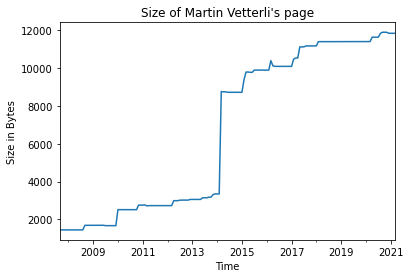

In [60]:
ax = psz.plot()
ax.set_title("Size of Martin Vetterli's page")
ax.set_xlabel("Time")
ax.set_ylabel("Size in Bytes")
ax.figure.savefig(os.path.join(im_path, "mirko.png"))

In [ ]:
def getPageScore(page):
    # Get mentions
    pms = getMentions(page, epfl_alts)
    
    if pms is None:
        return None
    
    # Get page views
    pvs = pageviews(page, stime, etime)
    
    # Get page size
    psz = getPageSize(page)
    
    # Combine the data
    df = pd.concat([pvs, psz.reindex(pvs.index), pms.reindex(pvs.index)], axis=1)
    df = df.ffill(axis=0)
    
    s_prev = psz.index.difference(pvs.index)
    s_fill = psz[s_prev[-1]] if len(s_prev) else 0
    df["Size"] = df["Size"].fillna(s_fill)
    
    m_prev = pms.index.difference(pvs.index)
    m_fill = pms[m_prev[-1]] if len(m_prev) else 0
    df["Mentions"] = df["Mentions"].fillna(m_fill)
    
    # Generate score
    df["Score"] = df["Mentions"] * df["Views"] / df["Size"]
    
    return df

In [ ]:
psc = getPageScore(page)
psc

In [ ]:
psc.plot()

## Editors

We will consider a user that changed their name as a new user for simplicity's sake.  
We do not use the function `page.contributors()` as it makes no distinction between regular and minor edits, and since we're going through the revisions we might as well extract that information in the process.

This can be improved by weighing the edits depending on the size increase of the page.

In [ ]:
revs = list(page.revisions(reverse=True, content=True))

In [ ]:
# Regular expressions to detect IP addresses and Bots.
pat_ip = re.compile('^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$|([0-9a-fA-F][0-9a-fA-F]{0,3}:){7}([0-9a-fA-F][0-9a-fA-F]{0,3}){1}')
pat_bot = re.compile(r'bot\b', re.IGNORECASE)

# Classify a user by its name into bots, real users, and IPs (unregistered users)
def classify_user(name):
    if pat_ip.match(name):
        return "IP"
    elif pat_bot.search(name):
        return "Bot"
    else:
        return "Real"

# Get user edit data from a page
def users(revs):
    # Get usernames and edit type
    df = pd.DataFrame([(r["user"], r["minor"]) for r in revs])
    
    # Set as index and sort 
    df.index = pd.MultiIndex.from_frame(df)
    df = df[[1]].sort_index(axis=0)
    
    # Group by user and edit type and split into columns
    df = pd.DataFrame(df.groupby(level=[0,1]).size())
    df = df.unstack(level=1, fill_value=0)
    
    # Rename columns and drop useless levels
    df = df.droplevel(level=0, axis=1)
    df.index.name = "Usernames"
    df.columns = ["Major", "Minor"]
    
    # Add user types as first index level
    df.index = pd.MultiIndex.from_tuples([classify_user(i), i] for i in df.index)
    
    return df.sort_index(axis=0)

In [ ]:
users(revs)

In [ ]:
ueds = users(revs)
ueds["Edits"] = ueds["Minor"] + ueds["Major"]

ax = sns.swarmplot(x=ueds.index.get_level_values(0), y="Edits", data=ueds)
ax.set_title("Editors for 'Martin Vetterli' on Wikipedia")
ax.figure.set_size_inches((9, 6))
    
ax.figure.savefig(os.path.join(im_path, "edits.png"))

In [ ]:
def mass_users(pages):
    # We'll want to get the bulk of the data out in the future
    
    temp = []
    
    for p in pages:
        curr = list(p.revisions(reverse=True, content=False))
        udata = users(curr)
        udata[p.title()] = udata["Minor"] + udata["Major"]
        temp.append(udata[p.title()])
    
    return pd.concat(temp, axis=1)

In [ ]:
udata = mass_users(epfl_pages[:100])
udata

In [ ]:
usr_sum = udata.sum(axis=1)
usr_sum

In [ ]:
usr_cnt = udata.count(axis=1)
usr_cnt

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Scatterplot of user edits")
ax.set_xlabel("Number of edits")
ax.set_ylabel("Number of pages")
x_vals = np.linspace(0, 100)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (120, 95))
fig.set_size_inches((9, 6))
artists = []
plot_names = []
for (ns, s), (nc, c) in zip(usr_sum.groupby(level=0), usr_cnt.groupby(level=0)):
    artists.append(plt.scatter(s, c))
    plot_names.append(ns)
ax.legend(artists, plot_names)
ax.figure.savefig(os.path.join(im_path, "users.png"))

In [ ]:
for (ns, s), (nc, c) in zip(usr_sum.groupby(level=0), usr_cnt.groupby(level=0)):
    print(s)

# WORK IN PROGRESS

need to make a record of what pages have indeed mentions or not so we can refer to it

In [ ]:
def saveData(page):
    ret = getPageScore(page)
    
    if ret is None:
        return None, None
    
    idx = page.data_item().title()
    ret.to_pickle(os.path.join("pickles", idx))
    return idx, ret

def loadData(idx):
    return pd.read_pickle(os.path.join("pickles", idx))

In [ ]:
'''

fns = os.listdir("pickles")
for p in epfl_pages:
    try:
        if p.data_item().title() not in fns:
            saveData(p)
            print(p)
    except:
        pass
'''

[[en:Whistleblower]]
WARNING: API warning (result): This result was truncated because it would otherwise be larger than the limit of 12,582,912 bytes.

In [ ]:
banane = pwb.Page(wiki_site, u"Fréquence Banane")
banane_s = getPageScore(banane)

In [ ]:
banane.data_item().title()

In [ ]:
banane_s.to_pickle(banane.data_item().title())

In [ ]:
pd.read_pickle(banane.data_item().title())

In [ ]:
saveData(banane)

In [ ]:
loadData("Q3090425")

In [ ]:
a = testdata[0]
b = testdata[1]
pd.concat([a, b], axis=1, keys=["u", "v"]).fillna(0).sum(axis=1, level=1)

In [ ]:
fns = [n for n in os.listdir("pickles") if n[0] == "Q"]
testdata = [loadData(fn) for fn in fns]

init = testdata[0]

for td in testdata[1:]:
    init = pd.concat([init, td], axis=1, keys=["l", "r"]).fillna(0).sum(axis=1, level=1)
    
init.plot()

In [ ]:
init["Views"].plot()

In [ ]:
init["Mentions"].plot()

In [ ]:
init["Score"].plot()

## Combining Data

In [ ]:
cl = pd.DataFrame(columns=["views", "mentions", "edits"])
cl.loc[495998] = [1, 2, 4]
cl

In [ ]:
for i, p in enumerate(epfl_pages[:10]):
    print(i)
    getPageScore(p)

## Editors

In [ ]:
for uid, dat in df.groupby("userid"):
    print(uid)
    for val, x in dat.groupby("minor"):
        print(val, sum(x["diff"]))

entry over time
* list of incoming links
* list of outgoing links
* mention history

work with user pages  
potentially use the wikipedia package for smaller operations as it seems to be faster, maybe do some timed tests

count improve counts by checking revisions 5 before and 5 after to ignore edit wars and such

Will need to handle the problem or redirects and page name changes in the future.

Will need to classify whether we found the subject through keywords or if EPFL was mentioned.

We assume mentions are only added for performance and simplicity reasons. It's very rare that content will be removed from pages.

Link pages with contributors

Update data over time instead of recomputing everything

Bot that changes names of EPFL or makes a suggestion on the talk page

orcid, unique identifier for papers

https://go.epfl.ch/wikiproject

correlate growth of epfl mentions and wikipedia in general (or science related pages, lets see what we can do)

In [ ]:
[r["size"] for r in revs][-5:]

In [ ]:
talkpage = pwb.Page(wiki_site, u"Talk:Martin Vetterli")
talkpage

In [ ]:
list(talkpage.categories())

In [ ]:
cats = list(page.categories())

In [ ]:
cats[0].categoryinfo

In [ ]:
# Function that checks that the category records are correct (if a page has been removed from a category, it will put it in the legacy records instead)
def sanitizeCategories():
    pass

In [ ]:
epfl_pages[:100]

In [ ]:
def extlink_data(page):
    links = [link.split("/", 5)[-1] if "web.archive.org" in link else link for link in page.extlinks()]
    domains = pd.DataFrame([tldextract.extract(link) for link in links], columns=["subdomain", "domain", "suffix"])
    
    try:
        domains["tld"] = domains["suffix"].str.split(".", expand=False).apply(lambda e : e[-1])
        domains["site"] = domains["domain"] + "." + domains["suffix"]
    except:
        pass

    sites = domains["site"].value_counts()
    tlds = domains["tld"].value_counts()
    return page.title(), sites, tlds

In [ ]:
titles, sites, tlds = extlink_data(page)
tlds

In [ ]:
sites

In [ ]:
temp = epfl_pages[:500]

series = np.array([extlink_data(t) for t in temp], dtype=object).transpose()

In [ ]:
pd.concat([pd.DataFrame(s, name=t) for t, s in tuple(series[0:2])])

In [ ]:
refs = pd.concat(series[1], axis=1, keys=series[0])
refs

In [ ]:
ref_sum = refs.sum(axis=1)
ref_sum[ref_sum > 600]

In [ ]:
ref_cnt = refs.count(axis=1)
ref_cnt

In [ ]:
ax = plt.scatter(ref_sum, ref_cnt).axes
ax.set_title("Scatterplot of domain repartition and frequency")
ax.set_xlabel("Number of occurences")
ax.set_ylabel("Number of pages")
fig = plt.gcf()
fig.set_size_inches((9, 6))
x_vals = np.linspace(0, 300)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (320, 280))
for t in ["epfl.ch", "unil.ch", "bbc.co.uk", "google.com", "nytimes.com"]:
    ax.scatter(ref_sum[t], ref_cnt[t], color="orange")
    ax.annotate(t, (ref_sum[t]+50, ref_cnt[t]+5), color="orange", bbox=dict(facecolor='white', boxstyle="round,pad=0.3"))
ax.figure.savefig(os.path.join(im_path, "domains.png"))

In [ ]:
refs_tld = pd.concat(series[2], axis=1, keys=series[0])
refs_tld

In [ ]:
ref_tld_sum = refs_tld.sum(axis=1)
ref_tld_sum

In [ ]:
ref_tld_cnt = refs_tld.count(axis=1)
ref_tld_cnt

In [ ]:
ax = plt.scatter(ref_tld_sum, ref_tld_cnt).axes
ax.set_title("Scatterplot of top-level-domain repartition and frequency")
ax.set_xlabel("Number of occurences")
ax.set_ylabel("Number of pages")
fig = plt.gcf()
fig.set_size_inches((9, 6))
x_vals = np.linspace(0, 450)
ax.plot(x_vals, x_vals)
ax.annotate("y = x", (720, 400))
for t in ["ch", "org", "com", "gov"]:
    ax.scatter(ref_tld_sum[t], ref_tld_cnt[t], color="orange")
    ax.annotate(t, (ref_tld_sum[t]+400, ref_tld_cnt[t]+1), color="orange", bbox=dict(facecolor='white', boxstyle="round,pad=0.3"))
ax.figure.savefig(os.path.join(im_path, "tlds.png"))

In [ ]:
import sys
temp = pd.concat(series[2], axis=1, keys=series[0])
sys.getsizeof(temp)

In [ ]:
temp2 = temp.astype(pd.SparseDtype("int", np.nan))
sys.getsizeof(temp2)

In [ ]:
pszs = [getPageSize(p) for p in epfl_pages[:10]]

In [ ]:
df = pd.concat(pszs, axis=1)
print(sys.getsizeof(df))

print(sys.getsizeof(df.astype(pd.SparseDtype("int", np.nan))))

# Page sizes

In [ ]:
# Need to make page to item and item to page functions
# Heavily bottlenecked by the `revisions` function unfortunately

# Gets given keys of all revisions after a given timestamp
def getRevisionsTags(page, ts, keys, content=False):
    gen = page.revisions(reverse=True, content=content)
    
    while True:
        try:
            v = next(gen)
            t = v["timestamp"]
            
            if ts is None or t > ts:
                yield t, [v[key] for key in keys]
            else:
                return
        except StopIteration:
            return

def updatePageSizes(pagecodes, rescan=False):
    path = os.path.join("pickles", "en_page_sizes.pkl")
    
    try:
        prev = pd.read_pickle(path)
    except:
        prev = pd.DataFrame()
        
    dfs = [prev]
    
    if rescan:
        pagecodes += list(prev.columns)
    
    for code in tqdm(pagecodes):
        try:
            # Recover page from code
            p = pwb.Page(wiki_site, pwb.ItemPage(repo, code).sitelinks["enwiki"].ns_title())
        except:
            continue

        # Set limit timestamp (or None if no data yet)
        ts = prev[code].last_valid_index() if code in prev.columns else None
        
        # Get values after that timestamp
        values = [(t, v[0]) for t, v in getRevisionsTags(p, ts, ["size"])]
        
        if len(values):
            # Sample every month and shift by 1 day to get 1st of month
            df = pd.DataFrame(values, columns=[0, code]).set_index(0)
            df = df.groupby(pd.Grouper(freq="1M")).nth(-1).resample("1M").pad()
            df.index = df.index.shift(1, freq="D")
            
            # Combine with old data if it exists
            if code in prev.columns:
                df = df.combine_first(prev[code])
                

            dfs.append(df)
    
    curr = pd.concat(dfs, axis=1)
    curr = curr.ffill(axis=0)
    curr.to_pickle(path)
    
    return curr

In [ ]:
pcodes = [p.data_item().title() for p in epfl_pages[:300]]
pszs = updatePageSizes(pcodes)

In [ ]:
pszs = pd.read_pickle("pickles/en_page_sizes.pkl")

In [ ]:
pszs

In [ ]:
total_size = pszs.sum(axis=1)
total_size.index.name = "Date"
total_size.name = "Select Pages Size"
total_size

In [ ]:
total_size.plot()

# Page count

Here we look at how many of our pages exist at a given time

In [ ]:
def pageCounts(df):
    ret = df.count(axis=1)
    ret.index.name = "Date"
    ret.name = "Select Pages Count"
    return ret

In [ ]:
pcnts = pageCounts(pszs)
pcnts

In [ ]:
pcnts.plot()

# Page size and page counts ratio

In [ ]:
(total_size / pcnts).plot()

In [ ]:
def loadWikistats(fn, name, exp=0):
    path = os.path.join("csv", "wikistats", fn)
    
    with open(path, "rb") as f:
        df = pd.read_csv(f)
        
    df.index = pd.to_datetime(df["month"], format="%Y-%m-%dT%H:%M:%S.%fZ").rename("Date")
    df = df["total.total"].rename(name) * 10**exp
        
    return df

In [ ]:
wiki_size = loadWikistats("size_change_en.csv", name="English Wikipedia Size", exp=0)
wiki_size = wiki_size[17:].cumsum()
wiki_size

In [ ]:
wiki_cnts = loadWikistats("pages_en.csv", name="English Wikipedia Count", exp=0)
wiki_cnts

In [ ]:
wiki_ratio = pd.concat([wiki_size, wiki_cnts], axis=1).dropna()
wiki_ratio = wiki_ratio.iloc[:,0] / wiki_ratio.iloc[:,1]
wiki_ratio.name = "English Wikipedia Ratio"
wiki_ratio.plot()
wiki_ratio

In [ ]:
pages_ratio = pd.concat([total_size, pcnts], axis=1).dropna()
pages_ratio = pages_ratio.iloc[:,0] / pages_ratio.iloc[:,1]
pages_ratio.name = "Select Pages Ratio"
pages_ratio.plot()
pages_ratio

In [ ]:
ax = pd.concat([total_size], axis=1).plot(logy=False, figsize=(9, 6))
ax.set_title("Size in Bytes")
ax.figure.savefig(os.path.join(im_path, "size_comp_lin.png"))

In [ ]:
ax = pd.concat([total_size, wiki_size], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Size in Bytes (log scale)")
ax.figure.savefig(os.path.join(im_path, "size_comp.png"))

In [ ]:
ax = pd.concat([pcnts, wiki_cnts], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Page counts (log scale)")
ax.figure.savefig(os.path.join(im_path, "count_comp.png"))

In [ ]:
ax = pd.concat([pages_ratio, wiki_ratio], axis=1).plot(logy=True, figsize=(9, 6))
ax.set_title("Size / Page Count Ratio (log scale)")
ax.figure.savefig(os.path.join(im_path, "ratio_comp.png"))

# Performance comparison

In [ ]:
import time
start = time.time()
page.revisions()
end = time.time()
print(end-start)

In [ ]:
print(epfl_pages[100].title())

In [ ]:
# Can only run on one page at a time
start = time.time()
revs = next(iter(api.PropertyGenerator('revisions', site=wiki_site, parameters={
    'titles': 'Martin Vetterli',
    'rvprop': 'timestamp|size',
})))['revisions']
end = time.time()
print(end-start)

In [ ]:
revs

In [ ]:
# Parallelize queries to the API

In [ ]:
mention_data = []
for p in epfl_pages[:100]:
    mention_data.append(getMentions(p, epfl_alts))

In [ ]:
mention_data